https://www.kaggle.com/carlosaguayo/deep-learning-for-text-classification/data

Toda a vez que for executar esse código subir os arquivos que estão no diretório artigos sobre deep learning

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.base import get_data_home
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Carregando o dataset
dataset = fetch_20newsgroups(subset='all', shuffle=True)

In [0]:
#Definindo constantes
max_length = 100
num_labels = 20
vocab_size = 20000
batch_size = [100]
epochs = [10]

# Pré-processando dos Dados
É necessário tokenizar o texto antes de podermos alimentá-lo em uma rede neural. Esse processo de tokenização também removerá alguns dos recursos do texto original, como todas as pontuações ou palavras menos comuns.

In [0]:
# Extract text
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(dataset.data)
sequences = tokenizer.texts_to_sequences(dataset.data) # Generate sequences
x = pad_sequences(sequences, maxlen=max_length)
# Extract target
y = to_categorical(np.asarray(dataset.target))

In [0]:
print('Shape of data:', x.shape)
print('Shape of labels:', y.shape)

Shape of data: (18846, 100)
Shape of labels: (18846, 20)


In [0]:
#Training and Test Sets
#this script divides data into 20% test set and 80% training set.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 

# Loading GloVe embeddings

In [0]:
link = 'https://drive.google.com/open?id=1erGe6LcwCDxpL9D8rRO7UYg0POVBvwX8'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1erGe6LcwCDxpL9D8rRO7UYg0POVBvwX8


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.6B.100d.txt') 

In [0]:
embeddings_index = {} # We create a dictionary of word -> embedding

with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [0]:
embedding_dim = 100 # We use 100 dimensional glove vectors

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) # How many words are there actually

embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [0]:
# create model
model = Sequential()
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=max_length, 
                    weights = [embedding_matrix], 
                    trainable = False))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(20, activation='softmax'))
model.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 128)            49280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 128)     

In [0]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15076 samples, validate on 3770 samples
Epoch 1/10
15076/15076 [==============================] - 8s 559us/step - loss: 2.1449 - acc: 0.2782 - val_loss: 1.5930 - val_acc: 0.4488
Epoch 2/10
15076/15076 [==============================] - 4s 291us/step - loss: 1.3384 - acc: 0.5542 - val_loss: 1.2810 - val_acc: 0.5745
Epoch 3/10
15076/15076 [==============================] - 4s 290us/step - loss: 1.0641 - acc: 0.6437 - val_loss: 1.1852 - val_acc: 0.6042
Epoch 4/10
15076/15076 [==============================] - 4s 287us/step - loss: 0.8742 - acc: 0.7102 - val_loss: 1.1923 - val_acc: 0.6300
Epoch 5/10
15076/15076 [==============================] - 4s 294us/step - loss: 0.6943 - acc: 0.7670 - val_loss: 1.1584 - val_acc: 0.6414
Epoch 6/10
15076/15076 [==============================] - 4s 289us/step - loss: 0.5310 - acc: 0.8210 - val_loss: 1.2681 - val_acc: 0.6239
Epoch 7/10
15076/15076 [====

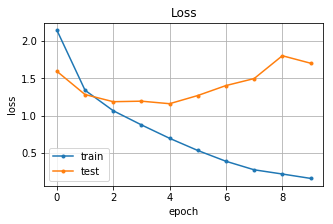

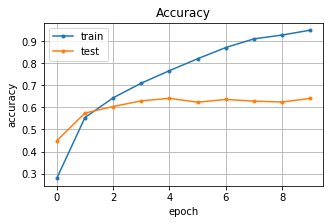

In [0]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='test')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['acc'], marker='.', label='train')
plt.plot(history.history['val_acc'], marker='.', label='test')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# Keras with GridsearchCV

In [0]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, 
                        weights = [embedding_matrix], 
                        trainable = False))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=100, verbose=0)

In [0]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10, verbose=True, return_train_score=True)
grid_result = grid.fit(x, y)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 19.9min finished


In [0]:
df = pd.DataFrame(grid_result.cv_results_)
df.to_csv('resultado_pipeline_naive_bayes.csv')
print(df.to_csv())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,28.870260572433473,1.412532302130017,0.3998705863952637,0.12008414029218001,SGD,{'optimizer': 'SGD'},0.949999988079071,0.949999988079071,0.949999988079071,0.949999988079071,0.949999988079071,0.949999988079071,0.949999990736603,0.949999990736603,0.949999990736603,0.949999990736603,0.9499999891417454,1.3018503336071051e-09,7,0.9499999878647037,0.9499999878647037,0.9499999878647037,0.9499999878647037,0.9499999878647037,0.9499999878647037,0.9499999882969397,0.949999

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.968863 using {'optimizer': 'Adagrad'}
0.950000 (0.000000) with: {'optimizer': 'SGD'}
0.968044 (0.001335) with: {'optimizer': 'RMSprop'}
0.968863 (0.001155) with: {'optimizer': 'Adagrad'}
0.965330 (0.001370) with: {'optimizer': 'Adadelta'}
0.968160 (0.001282) with: {'optimizer': 'Adam'}
0.967969 (0.001151) with: {'optimizer': 'Adamax'}
0.966762 (0.002148) with: {'optimizer': 'Nadam'}
